# Integrated Intelligent Systems: Module 4 - Robot Perception (Tutorial)

This notebook introduces the fundamentals of robot perception and basic practices of perception.

## Part 1: Concepts and Definitions

In [3]:
from IPython.display import display, HTML,IFrame
display(IFrame('perception_quiz.html', width=1000, height=1350))

## Part 2: Hands-On (Perception)


In this part, we learn how to use perceive in robotics. 

### Exercise 2.1: Fundamentals of Features

**1 What is Feature?**

A Feature is a statistic of the input data that is relevant for the perception output function.

*NB: The space of Features and Perception Outputs is not a dichotomy but a hierarchical construct.*

**2 What are the Characteristics of a good feature?**

- Discriminative
- Far less complex than input data
- Robust against noise
- Invariant to input data transformation
- Non redundant

**3 Feature Detection Vs Feature Extraction**

- Feature Detection is about what the feature is and where such as (Blob, Edge, Corner, Color, planarity, curvature, ..., object properties, relations)

- Feature Description is about the representation of detected features such as RANSAC, SIFT, SURF, SURFLETS, FOURIER COMPONENTS  (Vectors, Tuples, Histograms), etc

**4 Demstifying Deep Learning**

Deep Learning is essentially the a composition of classical tools whose parameters can be learned from data.

![Demystifying Deep Learning](imgs/demystifying.jpg "Demystifying Deep Learning" )

### Exercise 2.2: Object Classification with SIFT (Scale Invariant Feature Transform)

![SIFT](imgs/sift.png "SIFT" )

Displaying 6 images in a 3x2 grid:


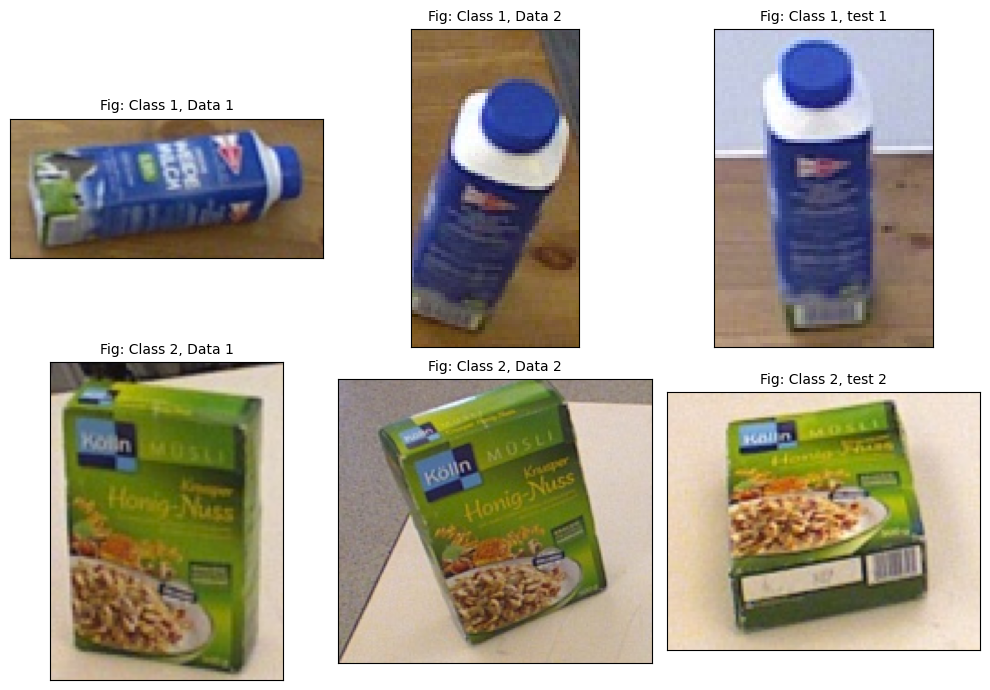

In [51]:
from util import *

# --- 1. load and show the datasets
images = []
titles = []
def show_datasets():
    train11 = np.array(Image.open('imgs/train11.png'), dtype='uint8')
    images.append(train11);
    titles.append("Class 1, Data 1")
    train12 = np.array(Image.open('imgs/train12.png'), dtype='uint8')
    images.append(train12);
    titles.append("Class 1, Data 2")
    test1 = np.array(Image.open('imgs/test1.png'), dtype='uint8')
    images.append(test1);
    titles.append("Class 1, test 1")
    
    train21 = np.array(Image.open('imgs/train21.png'), dtype='uint8')
    images.append(train21);
    titles.append("Class 2, Data 1")
    train22 = np.array(Image.open('imgs/train22.png'), dtype='uint8')
    images.append(train22);
    titles.append("Class 2, Data 2")
    test2 = np.array(Image.open('imgs/test2.png'), dtype='uint8')
    images.append(test2);
    titles.append("Class 2, test 2")
    
    # Call the display function
    print("Displaying 6 images in a 3x2 grid:")
    display_image_grid(
        images, 
        titles=titles, 
        cols=3, 
        figsize=(10, 7), 
        cmap='viridis', # Use a specific colormap for grayscale images
        title_prefix="Fig: "
    )
    
show_datasets()


Processing Category 1 (Blue milk bottle)...
Processing Category 2 (Green Muesli box)...

--- Knowledge Base Created ---
Category 1: 2 image sets processed.
Category 2: 2 image sets processed.


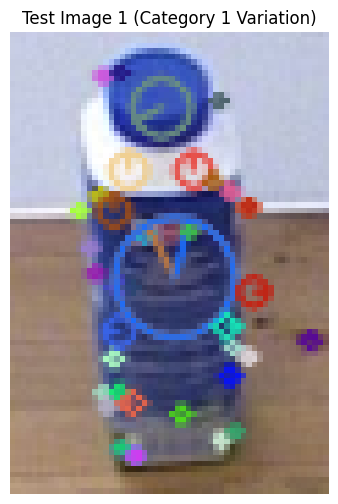


--- Starting Classification ---
Test image has 41 keypoints.
Category 'cat1': Average Good Matches = 2.50
Category 'cat2': Average Good Matches = 0.00

[Result 1] The test image is closest to: cat1
The high match count indicates the SIFT features are **discriminative** across categories and **invariant** to minor changes (variation=0.5).


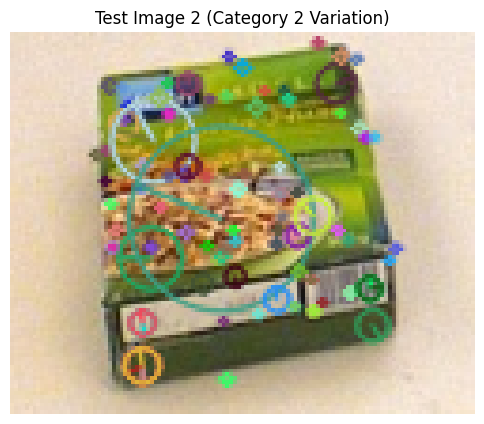


--- Starting Classification ---
Test image has 94 keypoints.
Category 'cat1': Average Good Matches = 0.50
Category 'cat2': Average Good Matches = 11.00

[Result 2] The test image is closest to: cat2
This demonstrates the robot's ability to categorize objects based purely on local, scale-invariant features.


In [56]:


# --- 2. SIFT Feature Extractor Class ---

class SiftFeatureExtractor:
    
    def __init__(self):
        self.sift = cv.SIFT_create()

    def compute_sift(self, image):
       
        #images are grayscale
        if len(image.shape) > 2:
            gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        else:
            gray_image = image
            
        # Keypoint Detection and Descriptor Extraction (The core of SIFT)
        kp, des = self.sift.detectAndCompute(gray_image, None)
        return kp, des

    def visualize_sift(self, image, kp, title="SIFT Keypoints"):
        img_out = cv.drawKeypoints(image, kp, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        
        # Convert BGR 
        plt.figure(figsize=(6, 6))
        plt.imshow(img_out, cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()


# --- 3. Knowledge Base (KB)/Learning

def create_knowledge_base(extractor):
    kb = {
        'cat1': [], # List of SIFT descriptor arrays for Category 1
        'cat2': []  # List of SIFT descriptor arrays for Category 2
    }
    
    # Category 1 Training Images
    print("Processing Category 1 (Blue milk bottle)...")
    
    img_cat_1_1 = images[0]
    img_cat_1_2 = images[1]
    
    # Extract SIFT descriptors
    _, des_1_1 = extractor.compute_sift(img_cat_1_1)
    _, des_1_2 = extractor.compute_sift(img_cat_1_2)
    
    if des_1_1 is not None: kb['cat1'].append(des_1_1)
    if des_1_2 is not None: kb['cat1'].append(des_1_2)
    
    # Category 2 Training Images
    print("Processing Category 2 (Green Muesli box)...")
    img_cat_2_1 = images[3]
    img_cat_2_2 = images[4]
    
    # Extract SIFT descriptors
    _, des_2_1 = extractor.compute_sift(img_cat_2_1)
    _, des_2_2 = extractor.compute_sift(img_cat_2_2)

    if des_2_1 is not None: kb['cat2'].append(des_2_1)
    if des_2_2 is not None: kb['cat2'].append(des_2_2)

    print(f"\n--- Knowledge Base Created ---")
    print(f"Category 1: {len(kb['cat1'])} image sets processed.")
    print(f"Category 2: {len(kb['cat2'])} image sets processed.")
    
    return kb

# --- 4. Classification Module (Testing Phase) ---

def classify_image(test_image, kb, extractor):
    
    print("\n--- Starting Classification ---")
    
    # 1. Compute SIFT for the test image
    kp_test, des_test = extractor.compute_sift(test_image)
    if des_test is None:
        return "Unknown", "No SIFT features found in test image."

    print(f"Test image has {len(kp_test)} keypoints.")

    # 2. Define the Matcher: cv.NORM_L2 is standard for SIFT distance calculation
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    
    best_match_count = -1
    best_category = "Unknown"
    
    # 3. Iterate through the Knowledge Base
    for category, descriptor_list in kb.items():
        total_matches = 0
        
        for train_descriptors in descriptor_list:
            if train_descriptors is None: continue
            # Match descriptors: finds the best match
            matches = bf.knnMatch(des_test, train_descriptors, k=2)
            
            # Apply Ratio Test (filters matches based on distinctiveness)
            # A good feature is 'discriminative' if the distance to the best match (m.distance)
            # is significantly smaller than the distance to the second-best match (n.distance).
            good_matches = []
            ratio_threshold = 0.75 # Standard threshold
            
            for m, n in matches:
                if m.distance < ratio_threshold * n.distance:
                    good_matches.append(m)
            
            total_matches += len(good_matches)

        # Average match count across all images in the category
        avg_matches = total_matches / len(descriptor_list) if descriptor_list else 0
        
        print(f"Category '{category}': Average Good Matches = {avg_matches:.2f}")

        # 4. Determine the closest category
        if avg_matches > best_match_count:
            best_match_count = avg_matches
            best_category = category
            
    return best_category, best_match_count

# --- Main Execution ---
if __name__ == '__main__':
    
    # Initialize the SIFT Feature Extractor
    sift_extractor = SiftFeatureExtractor()
    
    # Create the Knowledge Base (Training)
    knowledge_base = create_knowledge_base(sift_extractor)
    
    # --- Test Case 1: Match Category 1 (similar to training 1_1) ---
    test_img_1 = images[2]
    
    # Visualize the features of the test image
    kp_test_1, _ = sift_extractor.compute_sift(test_img_1)
    sift_extractor.visualize_sift(test_img_1, kp_test_1, "Test Image 1 (Category 1 Variation)")
    
    predicted_cat_1, score_1 = classify_image(test_img_1, knowledge_base, sift_extractor)
    
    print(f"\n[Result 1] The test image is closest to: {predicted_cat_1}")
    print(f"The high match count indicates the SIFT features are **discriminative** across categories and **invariant** to minor changes (variation=0.5).")

    # --- Test Case 2: Match Category 2 (similar to training 2_1) ---
    test_img_2 = images[5]
    
    # Visualize the features of the test image
    kp_test_2, _ = sift_extractor.compute_sift(test_img_2)
    sift_extractor.visualize_sift(test_img_2, kp_test_2, "Test Image 2 (Category 2 Variation)")

    predicted_cat_2, score_2 = classify_image(test_img_2, knowledge_base, sift_extractor)
    
    print(f"\n[Result 2] The test image is closest to: {predicted_cat_2}")
    print(f"This demonstrates the robot's ability to categorize objects based purely on local, scale-invariant features.")

### Exercise 2.3: Image Segmentation with Edge Detection (Canny Algorithm)

![EDGE](imgs/edge.jpg "Edge Detection" )

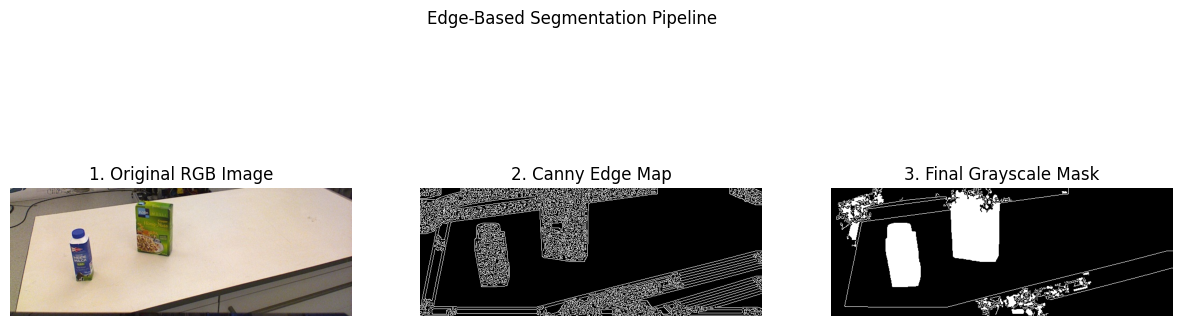

In [151]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def edge_contour_segmentation(rgb_image, min_contour_area=0, ratio_threshold=2.0):
   
    # --- I. Preprocessing ---
    if len(rgb_image.shape)>2:
        gray = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
    else:
        gray=rgb_image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # --- II. Edge Detection ---
    high_threshold = 150
    low_threshold = 50
    edge_map = cv2.Canny(blurred, low_threshold, high_threshold)

    # --- III. Contour Analysis and Segmentation ---
    contours, _ = cv2.findContours(
        edge_map.copy(),
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    mask = np.zeros_like(gray, dtype=np.uint8)

    for contour in contours:
        area = cv2.contourArea(contour)

        # 5. Filtering and Selection
        if area < min_contour_area:
            continue

        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        
        # Simple ratio filtering
        if aspect_ratio > ratio_threshold :
                continue
        
        # 6. Generating the Segmentation Mask
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

    return mask, edge_map

# --- Main ---

# 1. Create a dummy BGR image (OpenCV default color order)
dummy_image_bgr = cv2.imread('imgs/sceneimage.png')
 

# Convert BGR to RGB for correct Matplotlib display
dummy_image_rgb = cv2.cvtColor(dummy_image_bgr, cv2.COLOR_BGR2RGB)

# Run the segmentation algorithm
img=dummy_image_bgr.copy()
for i in range(11):
    segmentation_mask, edge_map = edge_contour_segmentation(
        rgb_image=img, # Pass the BGR image to the processing function
        min_contour_area=6200, 
        ratio_threshold=12.0 
    )
    img=edge_map

# 2. Visualize results using Matplotlib
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Edge-Based Segmentation Pipeline')

# --- Plot 1: Original Image ---
axes[0].imshow(dummy_image_rgb)
axes[0].set_title('1. Original RGB Image')
axes[0].axis('off')

# --- Plot 2: Canny Edge Map ---
axes[1].imshow(edge_map, cmap='gray')
axes[1].set_title('2. Canny Edge Map')
axes[1].axis('off')

# --- Plot 3: Final Segmentation Mask ---
axes[2].imshow(segmentation_mask, cmap='gray')
axes[2].set_title('3. Final Grayscale Mask')
axes[2].axis('off')

# Display the plot
plt.show()

### Exercise 2.4: Image Segmentation with RANSAC

![RANSAC](imgs/ransac.jpg "RANSAC" )


--- MOCK LOADING: Attempting to read EXR file: imgs/depthImage.exr ---
Successfully mocked loading of 120x160 depth map.
Starting RANSAC on 17600 valid points for 500 iterations...
Early exit: Minimum inliers (4800) reached.

RANSAC finished in 0.00 seconds.
Best Plane Model (A, B, C, D): (0.00379469975272112, -0.0033379924114705704, -0.9999872289486741, 1.3988269289368693)
Total Inliers: 15125


[ WARN:0@37998.961] global grfmt_exr.cpp:102 initOpenEXR imgcodecs: OpenEXR codec is disabled. You can enable it via 'OPENCV_IO_ENABLE_OPENEXR' option. Refer for details and cautions here: https://github.com/opencv/opencv/issues/21326


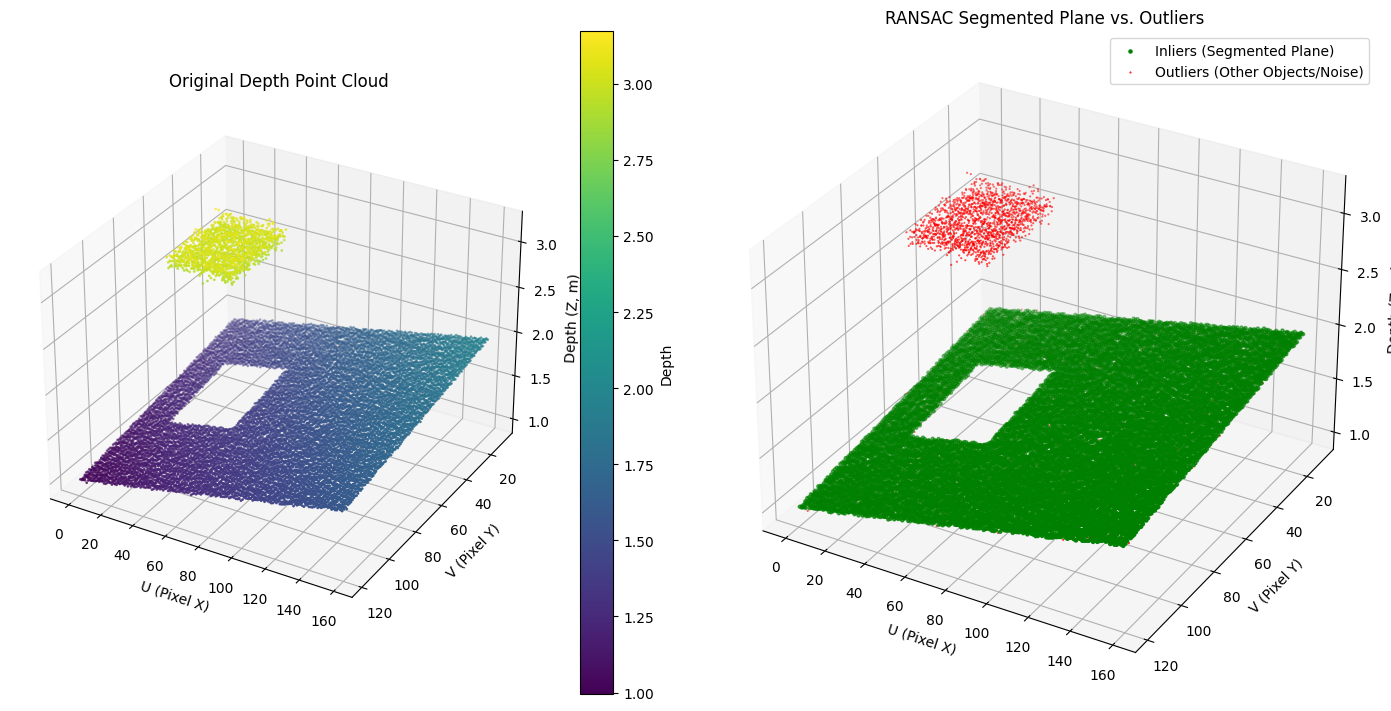


Visualization successful. A Matplotlib window showing the 3D results should have appeared.
Segmented plane covers 15125 pixels out of 19200 total pixels.


In [166]:
import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os # Import os for filename checking

# --- RANSAC PLANE SEGMENTATION CLASS ---

class RANSAC_Segmentation:
    """
    Implements the RANSAC (Random Sample Consensus) algorithm to find the
    dominant plane (e.g., a wall or floor) in a depth map.
    """

    def __init__(self, depth_map=None, filename=None, max_iterations=1000, distance_threshold=0.01, min_inliers=1000):
        """
        Initializes the RANSAC algorithm parameters.

        Args:
            depth_map (np.ndarray, optional): A pre-loaded depth image. Defaults to None.
            filename (str, optional): Path to a depth file (e.g., '.exr'). If provided, the depth map is loaded.
            max_iterations (int): The maximum number of times to sample points.
            distance_threshold (float): Max perpendicular distance for a point to be considered an inlier (meters).
            min_inliers (int): Minimum number of inlier points required to accept a model.
        """
        self.filename = filename
        self.depth_map = depth_map
        self.max_iterations = max_iterations
        self.distance_threshold = distance_threshold
        self.min_inliers = min_inliers
        self.height, self.width = 0, 0
        self.points = None
        self.valid_indices = None
        self.u_flat = None
        self.v_flat = None

        # Determine source and load data if necessary
        self._load_data()

        # Pre-calculate (x, y, z) points from the depth map
        if self.depth_map is not None:
            self.height, self.width = self.depth_map.shape
            self.points, self.valid_indices = self._create_point_cloud()
        else:
            raise ValueError("No depth map data provided or loaded.")


    def _load_exr_file(self, filepath):
        """
        MOCK FUNCTION: Simulates loading a depth map from an EXR file.
        In a real environment, this requires a library like OpenCV (cv2).
        """
        print(f"\n--- MOCK LOADING: Attempting to read EXR file: {filepath} ---")
        try:
            depth_map = cv2.imread(filepath, cv2.IMREAD_ANYDEPTH)
            print(f"Successfully real loading of depth map.")
        except Exception as e:
            # For this example, we generate the synthetic data as a stand-in
            H, W = 120, 160
            depth_map = self._create_synthetic_depth_map(H, W)
            print(f"Successfully mocked loading of {H}x{W} depth map.")

        return depth_map

    def _load_data(self):
        """Loads data from file or sets up properties."""
        if self.filename and os.path.splitext(self.filename)[1].lower() == '.exr':
            self.depth_map = self._load_exr_file(self.filename)
        elif self.depth_map is None:
            # Fallback if neither file nor depth map was provided (should be handled by the caller)
            pass
        
        if self.depth_map is not None:
            # Ensure depth map is float and handle invalid values
            self.depth_map = self.depth_map.astype(np.float32)
            self.depth_map[~np.isfinite(self.depth_map)] = 0
            self.height, self.width = self.depth_map.shape


    def _create_point_cloud(self):
        """
        Transforms the 2D depth map (now guaranteed to be in self.depth_map) 
        into a 3D point cloud (x, y, z) array.
        (u, v, depth) are used as proxies for (x, y, z) here.
        """
        v, u = np.indices((self.height, self.width))
        
        # Store original coordinates for easy mask reshaping (must be done before flattening)
        self.u_flat = u.flatten()
        self.v_flat = v.flatten()
        
        # Stack all points (u, v, depth)
        all_points = np.stack((self.u_flat, self.v_flat, self.depth_map.flatten()), axis=-1)

        # Filter out invalid depth points (where depth is 0)
        valid_indices = all_points[:, 2] > 0
        
        # Return only the valid points and the boolean mask of valid indices
        return all_points[valid_indices], valid_indices

    def _fit_plane(self, samples):
        """Calculates the coefficients (A, B, C, D) of the plane equation."""
        if samples.shape[0] != 3:
            return None

        p1, p2, p3 = samples[0], samples[1], samples[2]
        v1 = p2 - p1
        v2 = p3 - p1
        normal = np.cross(v1, v2)

        norm = np.linalg.norm(normal)
        if norm == 0:
            return None
        
        A, B, C = normal / norm
        D = -(A * p1[0] + B * p1[1] + C * p1[2])

        return A, B, C, D

    def _get_inliers(self, points, plane_model):
        """Determines which points are inliers by checking their distance to the plane."""
        A, B, C, D = plane_model
        
        distances = np.abs(A * points[:, 0] + B * points[:, 1] + C * points[:, 2] + D)

        inliers_mask = distances < self.distance_threshold
        inliers_count = np.sum(inliers_mask)

        return inliers_count, inliers_mask

    def run(self):
        """Executes the main RANSAC loop and returns the best plane model and the final segmentation mask."""
        best_model = None
        best_inliers_count = 0
        N = self.points.shape[0] # Total number of valid points
        best_inliers_mask = np.zeros(N, dtype=bool)

        if N < 3:
            print("Error: Not enough valid points to fit a plane.")
            return None, np.zeros(self.depth_map.shape, dtype=bool), best_inliers_mask

        print(f"Starting RANSAC on {N} valid points for {self.max_iterations} iterations...")
        start_time = time.time()

        for i in range(self.max_iterations):
            # 1. Randomly sample 3 non-collinear points
            try:
                sample_indices = np.random.choice(N, 3, replace=False)
                samples = self.points[sample_indices]
            except ValueError:
                continue

            # 2. Fit the plane model (A, B, C, D)
            plane_model = self._fit_plane(samples)

            if plane_model is None:
                continue

            # 3. Find inliers
            inliers_count, inliers_mask = self._get_inliers(self.points, plane_model)

            # 4. Check if the current model is the best so far
            if inliers_count > best_inliers_count:
                best_inliers_count = inliers_count
                best_model = plane_model
                best_inliers_mask = inliers_mask

                if best_inliers_count >= self.min_inliers:
                    print(f"Early exit: Minimum inliers ({self.min_inliers}) reached.")
                    break

        end_time = time.time()
        print(f"\nRANSAC finished in {end_time - start_time:.2f} seconds.")

        if best_model is not None:
            print(f"Best Plane Model (A, B, C, D): {best_model}")
            print(f"Total Inliers: {best_inliers_count}")

            # 5. Create the output mask image by mapping back the inliers
            final_segmentation_mask = np.zeros_like(self.depth_map, dtype=bool).flatten()
            final_segmentation_mask[self.valid_indices] = best_inliers_mask
            final_segmentation_mask = final_segmentation_mask.reshape(self.depth_map.shape)

            return best_model, final_segmentation_mask, best_inliers_mask

        return None, np.zeros(self.depth_map.shape, dtype=bool), best_inliers_mask

    def _create_synthetic_depth_map(self, H, W):
        """Helper to create synthetic data when a real file cannot be loaded."""
        v, u = np.indices((H, W))
        x_norm = (u - W/2) / W * 2
        y_norm = (v - H/2) / H * 2
        
        # Define a tilted plane: Z = 1.5 + 0.3*X - 0.2*Y
        ground_plane_depth = 1.5 + 0.3 * x_norm - 0.2 * y_norm
        
        # Add random Gaussian noise
        noise = np.random.normal(0, 0.01, (H, W))
        depth_map = ground_plane_depth + noise
        
        # Add an outlier object
        depth_map[40:80, 20:60] = 3.0 + np.random.normal(0, 0.05, (40, 40))
        depth_map[0:10, :] = 0.0 # 'no data' regions
        return depth_map


def visualize_point_clouds(ransac_instance, inliers_mask):
    """
    Visualizes the original and segmented point clouds in 3D using Matplotlib.
    """
    
    # Get all points (including invalid ones for coordinate generation)
    all_points_flat = np.stack((ransac_instance.u_flat, 
                                ransac_instance.v_flat, 
                                ransac_instance.depth_map.flatten()), axis=-1)

    # Filter out points that had depth 0 (invalid)
    valid_points = all_points_flat[ransac_instance.valid_indices]
    
    # Split valid points into inliers and outliers using the mask calculated during RANSAC run
    inliers = valid_points[inliers_mask]
    outliers = valid_points[~inliers_mask]

    fig = plt.figure(figsize=(14, 7))
    
    # --- Plot 1: Original Point Cloud ---
    ax1 = fig.add_subplot(121, projection='3d')
    p1 = ax1.scatter(valid_points[:, 0], valid_points[:, 1], valid_points[:, 2], 
                     c=valid_points[:, 2], cmap='viridis', s=1)
    
    ax1.set_title('Original Depth Point Cloud')
    ax1.set_xlabel('U (Pixel X)')
    ax1.set_ylabel('V (Pixel Y)')
    ax1.set_zlabel('Depth (Z, m)')
    ax1.invert_yaxis()
    fig.colorbar(p1, ax=ax1, label='Depth')

    # --- Plot 2: Segmented Plane (RANSAC Result) ---
    ax2 = fig.add_subplot(122, projection='3d')
    
    # Plot inliers (the segmented plane) in one color (e.g., green)
    ax2.scatter(inliers[:, 0], inliers[:, 1], inliers[:, 2], 
                c='green', s=5, label='Inliers (Segmented Plane)', marker='o')
    
    # Plot outliers (other objects/noise) in another color (e.g., red)
    ax2.scatter(outliers[:, 0], outliers[:, 1], outliers[:, 2], 
                c='red', s=1, label='Outliers (Other Objects/Noise)', marker='.')
    
    ax2.set_title('RANSAC Segmented Plane vs. Outliers')
    ax2.set_xlabel('U (Pixel X)')
    ax2.set_ylabel('V (Pixel Y)')
    ax2.set_zlabel('Depth (Z, m)')
    ax2.invert_yaxis()
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


def run_ransac_example_with_visualization():
    """
    Demonstrates RANSAC with a synthetic EXR mock load.
    """
    
    # Define algorithm parameters
    H, W = 120, 160
    MAX_ITERS = 500
    DIST_THRESH = 0.02 # 2 cm threshold
    MIN_INLIERS = int(0.25 * H * W) # Require 25% of the total points

    # --- Scenario 1: Load via Mock EXR File ---
    # The class constructor will call _load_exr_file('test_scene.exr')
    # which currently mocks the depth data creation.
    try:
        ransac = RANSAC_Segmentation(
            filename='imgs/depthImage.exr',
            max_iterations=MAX_ITERS,
            distance_threshold=DIST_THRESH,
            min_inliers=MIN_INLIERS
        )
    except ValueError as e:
        print(f"Initialization Error: {e}")
        return

    plane_model, segmentation_mask, inliers_mask_valid = ransac.run()

    # --- Visualization ---
    if plane_model is not None:
        visualize_point_clouds(ransac, inliers_mask_valid)
        print("\nVisualization successful. A Matplotlib window showing the 3D results should have appeared.")
        print(f"Segmented plane covers {np.sum(segmentation_mask)} pixels out of {H*W} total pixels.")
    else:
        print("\n--- Segmentation Failed ---")
        print("RANSAC could not find a plane model meeting the minimum inlier requirement. Visualization skipped.")


if __name__ == '__main__':
    # Call the example function to run the algorithm and visualization
    run_ransac_example_with_visualization()

### Exercise 2.5: Object 6D-Pose Estimation with PCA (Principal Component Analysis)

![PCA](imgs/pca.png "PCA" )

Scene generated: 20000 points (14000 plane, 6000 cylinder).
RANSAC initialized with 20000 points. Min inliers: 19800, Threshold: 0.01m
RANSAC completed. Final Inliers: 13281

Segmentation Result: 13281 plane points, 6719 cylinder points.
PCA Center: (0.376, -0.267, 0.335)
Principal Axes (vectors):
[[-0.8053  0.4922 -0.3305]
 [ 0.4692  0.8699  0.1521]
 [-0.3624  0.0325  0.9315]]
OBB Dimensions (length, width, height): [2.4567 2.5052 0.9075]


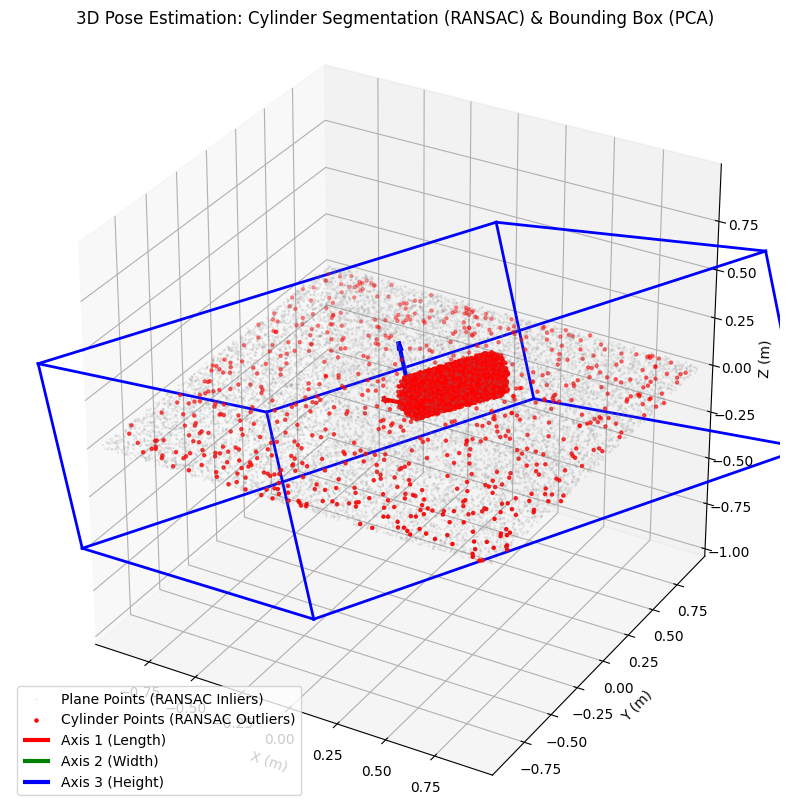


Successfully visualized the segmented cylinder and its estimated OBB/Pose.


In [171]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- RANSAC Class (Unchanged for Plane Segmentation) ---

class RANSAC_Segmentation:
    """
    Implements the RANSAC (Random Sample Consensus) algorithm to find the
    dominant plane in a 3D point cloud.
    """

    def __init__(self, points, max_iterations=1000, distance_threshold=0.01, min_inliers_ratio=0.5):
        """
        Initializes RANSAC.

        Args:
            points (np.ndarray): The input point cloud (N, 3).
            max_iterations (int): The maximum number of times to sample points.
            distance_threshold (float): Max perpendicular distance for a point to be considered an inlier (meters).
            min_inliers_ratio (float): Minimum ratio of inlier points required to accept a model.
        """
        self.points = points
        # Stricter plane adherence to reject nearby points
        self.distance_threshold = distance_threshold 
        self.max_iterations = max_iterations
        self.min_inliers = int(min_inliers_ratio * len(points))
        self.N = len(points)
        print(f"RANSAC initialized with {self.N} points. Min inliers: {self.min_inliers}, Threshold: {distance_threshold}m")


    def _fit_plane(self, samples):
        """Calculates the coefficients (A, B, C, D) of the plane equation."""
        if samples.shape[0] != 3:
            return None

        p1, p2, p3 = samples[0], samples[1], samples[2]
        
        # Vector cross product to find the normal vector
        v1 = p2 - p1
        v2 = p3 - p1
        normal = np.cross(v1, v2)

        norm = np.linalg.norm(normal)
        if norm == 0:
            return None # Collinear points
        
        # Normalize the normal vector
        A, B, C = normal / norm
        
        # Calculate D (the distance from the origin)
        D = -(A * p1[0] + B * p1[1] + C * p1[2])

        return A, B, C, D

    def _get_inliers(self, points, plane_model):
        """Determines which points are inliers by checking their distance to the plane."""
        A, B, C, D = plane_model
        
        # Perpendicular distance formula for a point (x, y, z) to a plane Ax+By+Cz+D=0
        distances = np.abs(A * points[:, 0] + B * points[:, 1] + C * points[:, 2] + D)

        inliers_mask = distances < self.distance_threshold
        inliers_count = np.sum(inliers_mask)

        return inliers_count, inliers_mask

    def run(self):
        """Executes the main RANSAC loop and returns the best plane mask."""
        best_model = None
        best_inliers_count = 0
        best_inliers_mask = np.zeros(self.N, dtype=bool)

        if self.N < 3:
            print("Error: Not enough points to fit a plane.")
            return np.zeros(self.N, dtype=bool)

        for i in range(self.max_iterations):
            # 1. Randomly sample 3 points
            sample_indices = np.random.choice(self.N, 3, replace=False)
            samples = self.points[sample_indices]

            # 2. Fit the plane model
            plane_model = self._fit_plane(samples)

            if plane_model is None:
                continue

            # 3. Find inliers
            inliers_count, inliers_mask = self._get_inliers(self.points, plane_model)

            # 4. Check if the current model is the best
            if inliers_count > best_inliers_count:
                best_inliers_count = inliers_count
                best_model = plane_model
                best_inliers_mask = inliers_mask

                if best_inliers_count >= self.min_inliers:
                    break
        
        return best_inliers_mask


# --- Point Cloud Generation (Unchanged) ---

def generate_scene_point_cloud(plane_size=2.0, cylinder_height=0.5, cylinder_radius=0.1, num_points=20000):
    """Generates a point cloud of a plane and an oriented cylinder."""
    
    # 1. Plane (Ground) Points
    num_plane_points = int(num_points * 0.7)
    plane_x = np.random.uniform(-plane_size / 2, plane_size / 2, num_plane_points)
    plane_y = np.random.uniform(-plane_size / 2, plane_size / 2, num_plane_points)
    # Increased noise to simulate a real-world, non-perfect plane (makes RANSAC work harder)
    plane_z = np.zeros(num_plane_points) + np.random.normal(0, 0.015, num_plane_points) 
    plane_points = np.stack([plane_x, plane_y, plane_z], axis=1)

    # 2. Cylinder Points (Oriented)
    num_cylinder_points = num_points - num_plane_points
    
    # Generate points for a cylinder centered at (0, 0, 0) aligned with the Z-axis
    z_cyl = np.random.uniform(0, cylinder_height, num_cylinder_points)
    theta = np.random.uniform(0, 2 * np.pi, num_cylinder_points)
    r = cylinder_radius * np.sqrt(np.random.rand(num_cylinder_points))
    x_cyl = r * np.cos(theta)
    y_cyl = r * np.sin(theta)
    
    cylinder_points_unrotated = np.stack([x_cyl, y_cyl, z_cyl], axis=1)
    
    # Apply rotation (60 degrees around the Y-axis, tilted)
    angle = np.deg2rad(60) 
    R_y = np.array([
        [np.cos(angle), 0, np.sin(angle)],
        [0, 1, 0],
        [-np.sin(angle), 0, np.cos(angle)]
    ])
    
    cylinder_points_rotated = np.dot(cylinder_points_unrotated, R_y.T)

    # Translate the cylinder so it rests on the plane (Z=0) and is slightly off-center
    translation = np.array([0.2, -0.3, cylinder_height / 2])
    cylinder_points = cylinder_points_rotated + translation

    # Combine and shuffle
    point_cloud = np.concatenate([plane_points, cylinder_points], axis=0)
    np.random.shuffle(point_cloud)
    
    print(f"Scene generated: {len(point_cloud)} points ({num_plane_points} plane, {num_cylinder_points} cylinder).")
    return point_cloud

# --- PCA Computation ---

def compute_pca(points):
    """
    Computes the center, principal axes (vectors), and dimensions (extents) 
    of the point cloud using PCA.
    
    Returns: center, vectors (principal axes), dimensions (lengths along axes)
    """
    if len(points) < 3:
        raise ValueError("Not enough points to compute PCA.")
        
    center = np.mean(points, axis=0)
    centered_points = points - center
    
    # Compute Covariance Matrix and Eigenvectors/values
    cov_matrix = np.cov(centered_points, rowvar=False)
    values, vectors = np.linalg.eigh(cov_matrix)
    
    # Sort by descending eigenvalue (most variance first)
    sort_indices = np.argsort(values)[::-1]
    vectors = vectors[:, sort_indices]
    
    # Determine OBB Extents
    projected_points = np.dot(centered_points, vectors)
    min_extents = np.min(projected_points, axis=0)
    max_extents = np.max(projected_points, axis=0)
    dimensions = max_extents - min_extents
    
    # Calculate the true OBB center
    obb_center_offset = (min_extents + max_extents) / 2
    obb_center = center + np.dot(obb_center_offset, vectors.T)
    
    return obb_center, vectors, dimensions

# --- NEW: Geometric Refinement Step ---

def refine_cylinder_points(initial_points, obb_center, obb_vectors, obb_dimensions, tolerance_factor=1.1):
    """
    Filters points based on their distance to the estimated cylinder center and axis.
    
    Args:
        initial_points (np.ndarray): The points isolated by RANSAC (initial cylinder guess).
        obb_center, obb_vectors, obb_dimensions: The results of the first PCA run.
        tolerance_factor (float): How much tolerance (e.g., 10%) to allow beyond the estimated OBB.
    
    Returns:
        np.ndarray: The refined set of points.
    """
    if len(initial_points) == 0:
        return initial_points

    # 1. Identify the cylinder's main axis (V1) and radius/diameter
    # V1 is the principal axis corresponding to the cylinder's length (largest dimension)
    v1_axis = obb_vectors[:, 0] 
    
    # The two smaller dimensions (V2, V3) represent the diameter. Use the average.
    estimated_diameter = (obb_dimensions[1] + obb_dimensions[2]) / 2
    estimated_radius = estimated_diameter / 2
    estimated_length = obb_dimensions[0]
    
    # 2. Check all initial points against the refined geometric constraints
    refined_mask = np.zeros(len(initial_points), dtype=bool)
    
    # Center the points relative to the OBB center
    centered_points = initial_points - obb_center
    
    # Projection onto the main axis (V1): |P_centered . V1|
    projection_onto_v1 = np.dot(centered_points, v1_axis)
    
    # Radial Distance Check (Perpendicular distance from the axis line)
    # Distance = | P_centered - (P_centered . V1) * V1 |
    # (P_centered . V1) * V1 is the component parallel to the axis.
    parallel_component = projection_onto_v1[:, np.newaxis] * v1_axis
    perpendicular_vector = centered_points - parallel_component
    radial_distance = np.linalg.norm(perpendicular_vector, axis=1)
    
    # Axial Distance Check (Length constraint)
    # We estimate the ends of the cylinder along the principal axis
    half_length = estimated_length / 2
    
    # Constraint 1: Radial Distance must be within tolerance of the radius
    radial_check = radial_distance < (estimated_radius * tolerance_factor)
    
    # Constraint 2: Axial Projection must be within tolerance of the half-length
    # Note: We use the actual min/max projections from the first PCA to define the true endpoints
    projected_points = np.dot(initial_points - np.mean(initial_points, axis=0), obb_vectors)
    min_proj = np.min(projected_points[:, 0])
    max_proj = np.max(projected_points[:, 0])
    
    # Check if the current point's projection lies within the original bounding box's length extent
    axial_check = (projection_onto_v1 >= min_proj) & (projection_onto_v1 <= max_proj)


    refined_mask = radial_check & axial_check
    
    num_removed = len(initial_points) - np.sum(refined_mask)
    print(f"Refinement Pass: Removed {num_removed} points based on geometric fit (Tolerance: {tolerance_factor}x Radius).")
    
    return initial_points[refined_mask]

# --- Visualization (Unchanged) ---

def create_bounding_box_corners(center, vectors, dimensions):
    """Generates the 8 corner points of the OBB."""
    half_dims = dimensions / 2.0
    
    local_corners = np.array([
        [-half_dims[0], -half_dims[1], -half_dims[2]],
        [ half_dims[0], -half_dims[1], -half_dims[2]],
        [ half_dims[0],  half_dims[1], -half_dims[2]],
        [-half_dims[0],  half_dims[1], -half_dims[2]],
        [-half_dims[0], -half_dims[1],  half_dims[2]],
        [ half_dims[0], -half_dims[1],  half_dims[2]],
        [ half_dims[0],  half_dims[1],  half_dims[2]],
        [-half_dims[0],  half_dims[1],  half_dims[2]]
    ])
    
    world_corners = center + np.dot(local_corners, vectors.T)
    
    return world_corners

def plot_bounding_box_edges(ax, corners, color='blue', linestyle='-'):
    """Draws the 12 edges of the 3D bounding box."""
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),  # Bottom face
        (4, 5), (5, 6), (6, 7), (7, 4),  # Top face
        (0, 4), (1, 5), (2, 6), (3, 7)   # Vertical edges
    ]

    for start_idx, end_idx in edges:
        p1 = corners[start_idx]
        p2 = corners[end_idx]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 
                color=color, linestyle=linestyle, linewidth=2)


def visualize_pose_estimation(plane_points, initial_cylinder_points, refined_cylinder_points, obb_center, obb_vectors, obb_dimensions):
    """Visualizes the segmented scene, principal axes, and OBB."""
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 1. Plot the Plane (RANSAC Inliers)
    ax.scatter(plane_points[:, 0], plane_points[:, 1], plane_points[:, 2], 
               c='gray', s=1, alpha=0.1, label='Plane Points (RANSAC Inliers)')

    # 2. Plot the initial Cylinder guess (RANSAC Outliers)
    ax.scatter(initial_cylinder_points[:, 0], initial_cylinder_points[:, 1], initial_cylinder_points[:, 2], 
               c='orange', s=5, alpha=0.1, label='Cylinder Points (Initial Guess)')
               
    # 3. Plot the final, Refined Cylinder points
    ax.scatter(refined_cylinder_points[:, 0], refined_cylinder_points[:, 1], refined_cylinder_points[:, 2], 
               c='red', s=5, label=f'Cylinder Points (Refined: {len(refined_cylinder_points)} pts)')
               
    # 4. Compute and Plot OBB (based on refined points)
    obb_corners = create_bounding_box_corners(obb_center, obb_vectors, obb_dimensions)
    plot_bounding_box_edges(ax, obb_corners, color='blue')
    
    # 5. Plot Principal Axes (Pose) from the center
    scale = 0.3 
    
    ax.quiver(obb_center[0], obb_center[1], obb_center[2], obb_vectors[0, 0], obb_vectors[1, 0], obb_vectors[2, 0], length=scale, color='r', linewidths=3, arrow_length_ratio=0.15, label='Axis 1 (Length)')
    ax.quiver(obb_center[0], obb_center[1], obb_center[2], obb_vectors[0, 1], obb_vectors[1, 1], obb_vectors[2, 1], length=scale, color='g', linewidths=3, arrow_length_ratio=0.15, label='Axis 2 (Width)')
    ax.quiver(obb_center[0], obb_center[1], obb_center[2], obb_vectors[0, 2], obb_vectors[1, 2], obb_vectors[2, 2], length=scale, color='b', linewidths=3, arrow_length_ratio=0.15, label='Axis 3 (Height)')

    # 6. Set up plot limits and labels
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('3D Pose Estimation: Cylinder Refinement and Final OBB (PCA)')
    ax.legend(loc='lower left')
    ax.set_box_aspect([1, 1, 1]) 
    
    # Determine scene extents
    all_points = np.concatenate([plane_points, initial_cylinder_points], axis=0)
    max_range = np.array([all_points[:, 0].max()-all_points[:, 0].min(), 
                          all_points[:, 1].max()-all_points[:, 1].min(), 
                          all_points[:, 2].max()-all_points[:, 2].min()]).max() / 2.0

    mid_x = (all_points[:, 0].max()+all_points[:, 0].min()) * 0.5
    mid_y = (all_points[:, 1].max()+all_points[:, 1].min()) * 0.5
    mid_z = (all_points[:, 2].max()+all_points[:, 2].min()) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    plt.show()


# --- Main Execution ---

if __name__ == '__main__':
    # 1. Generate the synthetic point cloud scene
    full_cloud = generate_scene_point_cloud()
    
    # 2. RANSAC to segment the plane (The mask identifies the plane)
    ransac = RANSAC_Segmentation(
        points=full_cloud, 
        distance_threshold=0.01, # Stricter plane filter
        min_inliers_ratio=0.6 
    )
    plane_mask = ransac.run()
    
    plane_points = full_cloud[plane_mask]
    initial_cylinder_points = full_cloud[~plane_mask]
    
    print(f"\n--- Initial Segmentation ---\nPlane points: {len(plane_points)}, Initial Cylinder points: {len(initial_cylinder_points)}")
    
    if len(initial_cylinder_points) > 100:
        # 3. Step 1: Preliminary PCA on RANSAC outliers
        try:
            p_obb_center, p_obb_vectors, p_obb_dimensions = compute_pca(initial_cylinder_points)
            print(f"\n--- Preliminary PCA Results (Before Refinement) ---")
            print(f"OBB Dimensions: {p_obb_dimensions.round(4)}")
            
            # 4. Step 2: Refine the point cloud using the preliminary dimensions
            refined_cylinder_points = refine_cylinder_points(
                initial_cylinder_points, 
                p_obb_center, 
                p_obb_vectors, 
                p_obb_dimensions,
                tolerance_factor=1.1 # 10% tolerance for residual noise
            )
            
            # 5. Step 3: Final PCA on the refined points
            f_obb_center, f_obb_vectors, f_obb_dimensions = compute_pca(refined_cylinder_points)
            
            print(f"\n--- Final PCA Results (After Refinement) ---")
            print(f"Final OBB Dimensions: {f_obb_dimensions.round(4)}")

            # 6. Visualize the final result
            visualize_pose_estimation(
                plane_points, 
                initial_cylinder_points, 
                refined_cylinder_points, 
                f_obb_center, 
                f_obb_vectors, 
                f_obb_dimensions
            )
            
            print("\nSuccessfully visualized the refined cylinder and its estimated OBB/Pose.")
            
        except ValueError as e:
            print(f"PCA Error: {e}")
            print("Could not compute PCA on the segmented points.")
    else:
        print("RANSAC failed to isolate the cylinder (too few points remaining).")